# Initial Data Download

In [7]:
#Download the Amazon review dataset
!curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz

tar: Error opening archive: Failed to open '\\.\tape0'
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 21.8M    0  101k    0     0  46796      0  0:08:08  0:00:02  0:08:06 47071
  2 21.8M    2  560k    0     0   172k      0  0:02:09  0:00:03  0:02:06  173k
  5 21.8M    5 1308k    0     0   300k      0  0:01:14  0:00:04  0:01:10  301k
  8 21.8M    8 1835k    0     0   351k      0  0:01:03  0:00:05  0:00:58  367k
 11 21.8M   11 2532k    0     0   406k      0  0:00:54  0:00:06  0:00:48  507k
 15 21.8M   15 3365k    0     0   465k      0  0:00:47  0:00:07  0:00:40  651k
 18 21.8M   18 4232k    0     0   514k      0  0:00:43  0:00:08  0:00:35  7

# Library Import

In [122]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import string
import re
import statsmodels.api as sm
import statsmodels.tools as smt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import chi2
import spacy
from spacy.lookups import Lookups
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.lemmatizer import Lemmatizer
from bs4 import BeautifulSoup

pd.set_option('display.width', 1000)

# Initial Data Exploration

In [2]:
df = pd.read_csv('amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz', compression='gzip', header=0, 
                 sep='\t+', quotechar='"', encoding='utf-8', engine='python')

In [4]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5,0,0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5,0,1,N,Y,five star,it's great,2015-08-31
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5,0,0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4,0,0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2,0,0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31


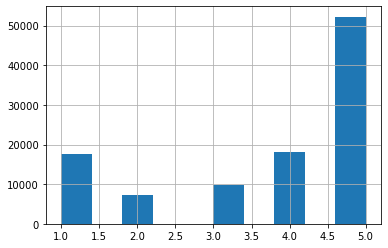

In [5]:
df.star_rating.hist()

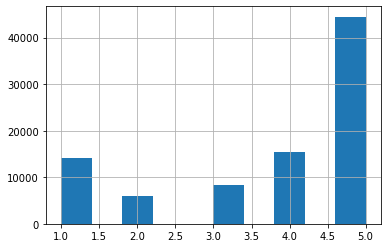

In [6]:
df.loc[df.verified_purchase=='Y'].star_rating.hist()

Since the focus on this project is to predict positive and negative feedback, I have decided to discard the neutral comments. It is also important to filter by verified purchase flag.

In [3]:
df = df.loc[np.logical_and(df.verified_purchase == 'Y', df.star_rating != 3)].reset_index()

I noticed that the review headline could be useful so I will create a new column that combines both headline and body. I will also simplify the sentiment rating which will be the target variable into 0 if it has less than 3 stars or 1 if it has more than 3 stars. Basically, this variable represents whether the review is positive or not.

In [4]:
df['full_review'] = df['review_headline'] + " " + df['review_body']
df['sentiment'] = np.where(df.star_rating < 3, 0, 1)

In [9]:
df.head(5)

,index,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,full_review,sentiment
0,0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5,0,0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31,Very Happy! As advertised. Everything works pe...,1
1,1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5,0,1,N,Y,five star,it's great,2015-08-31,five star it's great,1
2,2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5,0,0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31,great cables These work great and fit my life ...,1
3,3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4,0,0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31,Work very well but couldn't get used to not he...,1
4,4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2,0,0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31,Cameras has battery issues Be careful with the...,0


In [10]:
df.shape

(80197, 18)

# Balancing the Datasets

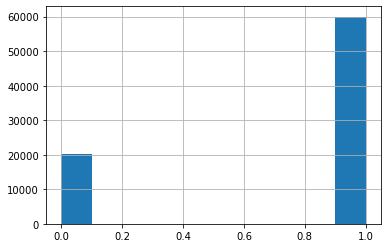

In [14]:
df.sentiment.hist()

In [8]:
balanced_df = df.loc[df.sentiment == 0]\
                .append(df.loc[df.sentiment == 1].sample(n=df.loc[df.sentiment==0].shape[0],random_state=1234))\
                .reset_index()

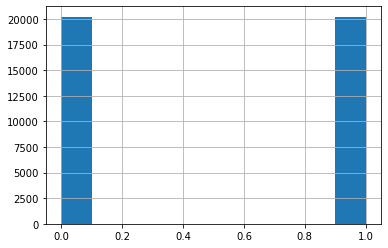

In [16]:
balanced_df.sentiment.hist()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df.full_review, balanced_df.sentiment, train_size = 0.7, 
                                                    random_state = 1234, stratify=balanced_df.sentiment)

In [18]:
X_train.shape

(28299,)

# NLP: Tokenising and Bag of Words

In [5]:
nlp = spacy.load('en_core_web_sm')

In [6]:
lookups = Lookups()
lookups.add_table("lemma_rules", {"noun": [["s",""]]})
lemmatizer = Lemmatizer(lookups)
PUNCTUATIONS = string.punctuation

In [168]:
#Function for tokenizing and removing punctuations and stop words
def tokeniser(text):
    tokens = nlp(BeautifulSoup(text).get_text())
    result = []
    for token in tokens:
        if token.pos_ not in ["SYM", "NUM"] and token.is_stop == False and token.is_punct == False and token.is_space == False:
            word = token.lemma_
            if token.lemma_ != "-PRON-":
                word = token.lemma_.lower()
            else:
                word = token.lower_
            word = re.sub(r'\W+\d+', '', word).strip()
            result.append(word)
    result = [re.sub(r'\W+\d+', '', word).strip(PUNCTUATIONS) for word in result if word]
    return result

In [173]:
bow = CountVectorizer(tokenizer = tokeniser, ngram_range=(1,1))

In [59]:
tfidf = TfidfVectorizer(tokenizer = tokeniser)

In [ ]:
tfidf_model = tfidf.fit_transform(X_train[:1000].values.astype('U'))

In [24]:
tfidf_model.shape

(28299, 37107)

In [165]:
bow_df = bow.fit_transform(X_train[:1000].values.astype('U'))

In [144]:
tokeniser('013mm beauty-oriented')

['mm', 'beauty', 'orient']

In [166]:
bow_df.shape

(1000, 4135)

In [54]:
#re.split('\W+', 'a!!!!the')
bool(re.search('\W+\d+', 'alternative'))

False

In [159]:
X_train[:1000]

12445    Overpriced, under performed, cheaply manufactu...
34092    From The Mind Of Bob Whether you want one of t...
27650    Great basic armband I needed something to carr...
38147    Excellent Screen Protector This is the first s...
9888     Don't They don't protect (I used two in less t...
                               ...                        
1105     don't waste your $$$ can't even use...worthles...
8647     Can't see my screen! I don't know why I though...
37618    Wonderful Choice! Was very pleased with the qu...
6101     Broken twice You payfor what you get. Cheap cr...
29718    Handy I bought this for my daughter's Nabi 2.<...
Name: full_review, Length: 1000, dtype: object

In [160]:
X_train[1105]

"don't waste your $$$ can't even use...worthless junk..don't waste your $$$"

In [169]:
tokeniser(X_train[38951])

['daughter',
 'love',
 'need',
 'say',
 'good',
 'product',
 'excellent',
 'price',
 'fit',
 'stylin',
 'kid']

In [170]:
tokeniser(X_train[38360])

['worth',
 'like',
 'sub',
 'boss',
 'amp',
 'power',
 'sound',
 'great',
 'definitely',
 'worth',
 'money']

In [172]:
tokeniser("it works great on my player. finally get to enjoy all these great albums again.	2012-02-09 US	32571980	RUR3WJHJQJNTQ	B001VICP1C	737387752	PHILIPS AMPLIFIER 24DB VHF UHF FM	Mobile_Electronics	1	0	0	N	Y	Waste of money and time..!!!BEWARE!!!	Just looking for a cheap amp, as the one I own was having problems.")

['work',
 'great',
 'player',
 'finally',
 'enjoy',
 'great',
 'album',
 'rur3wjhjqjntq',
 'b001vicp1c',
 'philip',
 'amplifier',
 'vhf',
 'uhf',
 'fm',
 'mobile_electronics',
 'y',
 'waste',
 'money',
 'time',
 'beware',
 'look',
 'cheap',
 'amp',
 'have',
 'problem']

In [167]:
bow.get_feature_names()

['!!!beware',
 '+',
 '-)rear',
 '---and',
 '--stay',
 '->midbass',
 '->midrange',
 '->tweet',
 '-at',
 '-c1',
 '-pron-',
 '.rkp',
 '.would',
 '1',
 '10\\\\',
 '120sr',
 '12\\\\',
 '12v',
 '1450lmt',
 '1\\\\',
 '1a',
 '1d',
 '1st',
 '2',
 '20minute',
 '21khz',
 '23rd',
 '250a',
 '265w',
 '29or',
 '2nd',
 '2xx',
 '3',
 '3-way',
 '30""',
 '32nd',
 '36th',
 '3db',
 '3generation',
 '3gs',
 '3rd',
 '433iv',
 '4gs',
 '4s',
 '4th',
 '5',
 '55w',
 '5c',
 '5s',
 '5th',
 '600w',
 '66mlt',
 '6\\\\',
 '6th',
 '6x7',
 '75hz',
 '8ga',
 '9db',
 '9v',
 '<',
 '=',
 '=)',
 '>',
 '[[asin',
 '\\\\"aside',
 '\\\\"aux\\\\',
 '\\\\"bassy\\\\',
 '\\\\"bezel\\\\',
 '\\\\"big',
 '\\\\"book',
 '\\\\"charging',
 '\\\\"deal\\\\',
 '\\\\"field',
 '\\\\"fit\\\\',
 '\\\\"frustrating\\\\',
 '\\\\"good\\\\',
 '\\\\"green\\\\',
 '\\\\"grips\\\\',
 '\\\\"happy',
 '\\\\"i',
 '\\\\"leather',
 '\\\\"make',
 '\\\\"mount\\\\',
 '\\\\"naked\\\\',
 '\\\\"name',
 '\\\\"nice',
 '\\\\"no',
 '\\\\"ok\\\\',
 '\\\\"original\\\\',
 '\\

In [124]:
chi2score = chi2(bow_df, y_train[:1000])[0]

plt.figure(figsize=(15,10))
wscores = zip(bow.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = zip(*wchi2[-20:])
#x = range(len(topchi2[1]))
#labels = topchi2[0]
#plt.barh(x,topchi2[1], align='center', alpha=0.2)
#plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
#plt.yticks(x, labels)
#plt.xlabel('$\chi^2$')

<Figure size 1080x720 with 0 Axes>

In [129]:
wchi2

[('12v', 0.0002880414779728286),
 ('3way', 0.0002880414779728286),
 ('a', 0.0002880414779728286),
 ('accomplish', 0.0002880414779728286),
 ('accord', 0.0002880414779728286),
 ('accuracy', 0.0002880414779728286),
 ('adhere', 0.0002880414779728286),
 ('advice', 0.0002880414779728286),
 ('age', 0.0002880414779728286),
 ('agree', 0.0002880414779728286),
 ('alright', 0.0002880414779728286),
 ('ambient', 0.0002880414779728286),
 ('anybody', 0.0002880414779728286),
 ('anytime', 0.0002880414779728286),
 ('approximately', 0.0002880414779728286),
 ('arrange', 0.0002880414779728286),
 ('art', 0.0002880414779728286),
 ('aside', 0.0002880414779728286),
 ('assemble', 0.0002880414779728286),
 ('assume', 0.0002880414779728286),
 ('audiobook', 0.0002880414779728286),
 ('awhile', 0.0002880414779728286),
 ('background', 0.0002880414779728286),
 ('backup', 0.0002880414779728286),
 ('bank', 0.0002880414779728286),
 ('bell', 0.0002880414779728286),
 ('blackberry', 0.0002880414779728286),
 ('block', 0.000288